In [53]:
!pip install -q  fastai==1.0.61

In [54]:
# check version of fastai
import fastai

fastai.__version__

'1.0.61'

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastai import *
from fastai.vision import *
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# No need to reload the notebook if any change in the fastai library
%reload_ext autoreload
%autoreload 2

In [56]:
img_path = "../input/ksl-signs/Images"

## [Data augmentation using tfms for better pixel values](https://fastai1.fast.ai/vision.transform.html#Data-augmentation)

* Fastai v1 has a method `get_transforms()` which applies default and random transformations with a probability of 75%: crop, horizontal flip, zoom up to 1.1, brightness and contrast, wrap (perspective). It returns 2 sets of transformations, one for the training images (get_transforms()[0]), and the other for the validation ones (get_transforms()[1]). [Read here](https://medium.com/@pierre_guillou/data-augmentation-by-fastai-v1-84ca04bea302)

In [102]:
# get list of images
fnames = get_image_files(img_path)

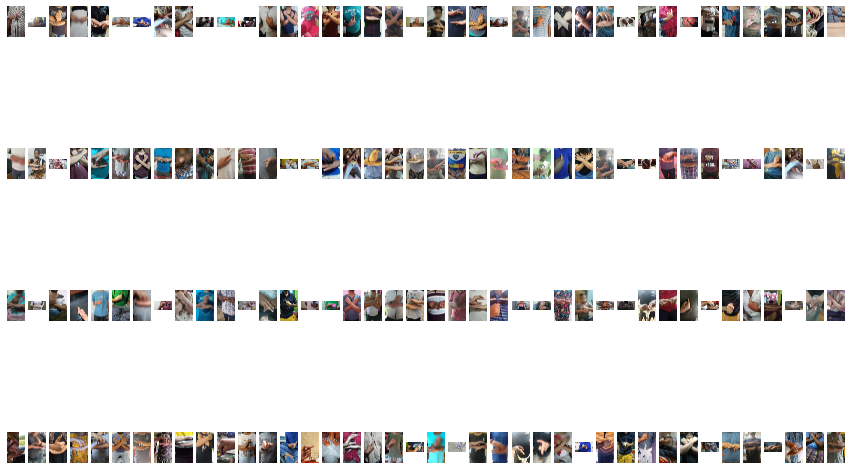

In [107]:
tfms=get_transforms(do_flip = True, 
                    flip_vert = False, 
                    max_rotate  = 10.0, 
                    max_zoom = 1.1, 
                    max_lighting = 0.2, 
                    max_warp = 0.2, 
                    p_affine = 0.75, 
                    p_lighting = 0.75, 
                   )

# Function that returns an image from its url
def get_img(img_url): return open_image(img_url)


# Function that displays one image after transformations
def display_img_after_tfms(img_url, tfms, ax, label):
        img = get_img(img_url).apply_tfms(tfms=tfms, size=224)
        img.show(ax=ax)
        ax.set_title(x=0.5,y=-0.1, label=label)
        
fig, axs = plt.subplots(4,40,figsize=(15,10))
for i, ax in enumerate(axs.flatten()):
    img = get_img(fnames[i])
    img.show(ax=ax)
plt.show()

In [108]:
df = pd.read_csv("../input/kslc-dataset/train.csv")
df.head()

,img_IDS,Label
0,ImageID_33HMDMJ3,Temple
1,ImageID_V5POEX4O,Church
2,ImageID_89CCCCW6,Enough/Satisfied
3,ImageID_GNJXOWX5,Me
4,ImageID_7Q9LOP7R,Love


In [110]:
# Create ImageDataBunch with transformations  
data = ImageDataBunch.from_df(img_path,
                              df,
                              size=224,
                              valid_pct=0.20,
                              ds_tfms=tfms,
                              num_workers=2,
                              bs=8,
                             suffix='.jpg').normalize(imagenet_stats)
print(data.c)

9


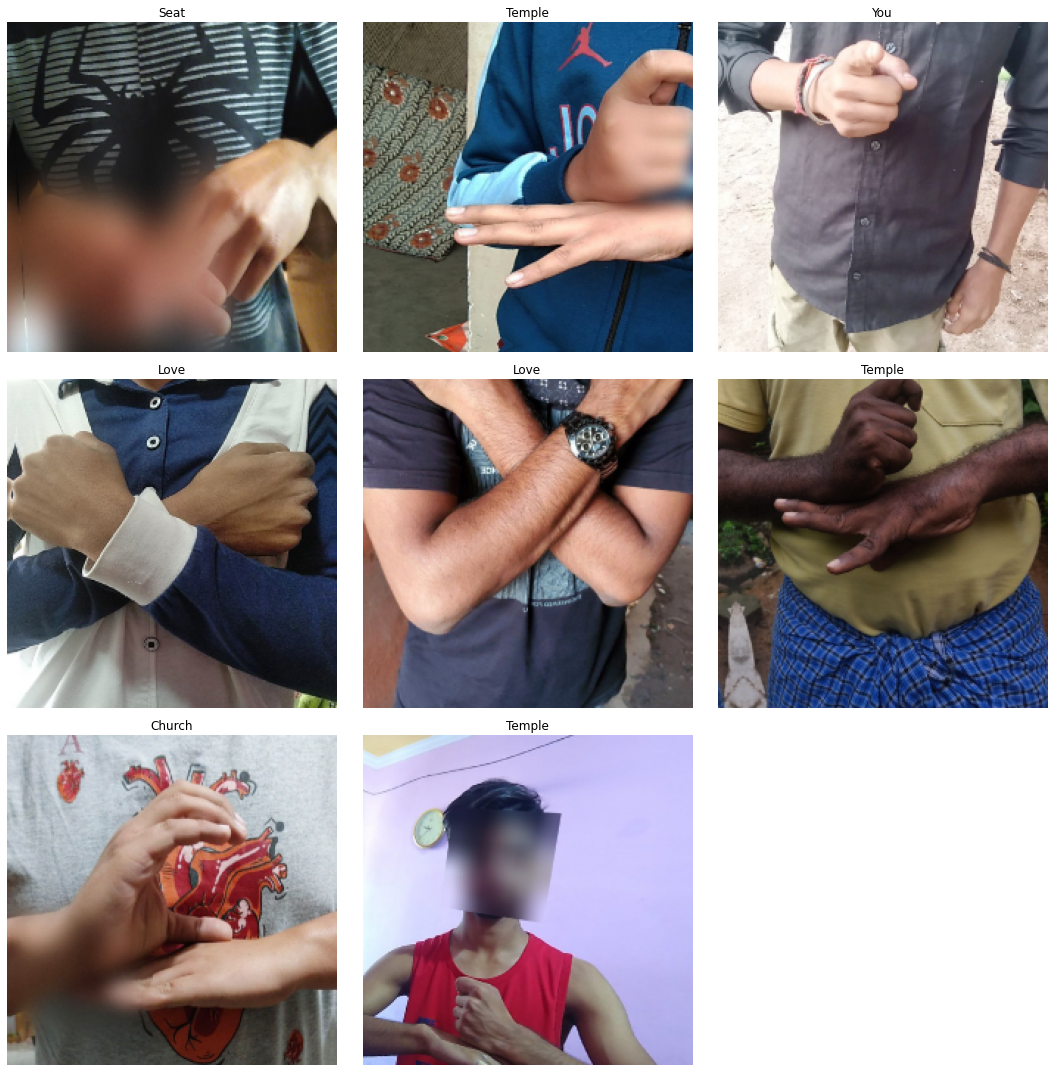

In [111]:
# Look at some examples
data.show_batch(rows=3, figsize=(15, 15)) 

## Baseline
* Using resnet model

In [112]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

# Fit
num_epochs = 3
learn.fit_one_cycle(num_epochs, 1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.715583,1.635098,0.570056,0.429944,05:04
1,1.968781,1.135456,0.393915,0.606085,05:05
2,1.891050,1.076092,0.368295,0.631705,05:09


## [Learning Rate Finder](https://medium.com/analytics-vidhya/the-learning-rate-finder-9203fdc67c92)
* Hyper-parameter which controls the rate or speed at which the model learns.

## Prediction on Test Set

In [73]:
test = pd.read_csv("/kaggle/input/kslc-dataset/test.csv")
test.head()

,img_IDS
0,ImageID_USRB8QNG
1,ImageID_SZ8D1ZJI
2,ImageID_4OJO2F8J
3,ImageID_IEE4XV0B
4,ImageID_BP0O0WZ9


In [74]:
test = ImageList.from_df(test, img_path, suffix='.jpg')
data.add_test(test)

In [75]:
preds_test,y_test = learn.get_preds(DatasetType.Test)

In [76]:
preds_test[:,1]

tensor([0.1353, 0.5783, 0.2290,  ..., 0.0753, 0.0753, 0.0377])

In [77]:
y_test

tensor([0, 0, 0,  ..., 0, 0, 0])

In [80]:
sub = pd.read_csv('/kaggle/input/kslc-dataset/sample_submission.csv')
print(sub.head())
k=[]
for col in sub.columns: 
    k.append(col) # creating list of the label

            img_IDS  Church  Enough/Satisfied  Friend  Love  Me  Mosque  Seat  \
0  ImageID_USRB8QNG     NaN               NaN     NaN   NaN NaN     NaN   NaN   
1  ImageID_SZ8D1ZJI     NaN               NaN     NaN   NaN NaN     NaN   NaN   
2  ImageID_4OJO2F8J     NaN               NaN     NaN   NaN NaN     NaN   NaN   
3  ImageID_IEE4XV0B     NaN               NaN     NaN   NaN NaN     NaN   NaN   
4  ImageID_BP0O0WZ9     NaN               NaN     NaN   NaN NaN     NaN   NaN   

   Temple  You  
0     NaN  NaN  
1     NaN  NaN  
2     NaN  NaN  
3     NaN  NaN  
4     NaN  NaN  


In [81]:
submission = sub.copy()
for i, c in enumerate(learn.data.classes):
    submission[c] = preds_test[:,i]
submission = submission[k] # Get same order as sample sub
submission.head()

,img_IDS,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
0,ImageID_USRB8QNG,0.047708,0.135316,0.175709,0.013775,0.006267,0.054887,0.076043,0.268354,0.221941
1,ImageID_SZ8D1ZJI,0.033824,0.578253,0.003744,0.015283,0.084402,0.215057,0.006730,0.054329,0.008378
2,ImageID_4OJO2F8J,0.118449,0.229040,0.027513,0.011576,0.005278,0.563155,0.009619,0.028129,0.007241
3,ImageID_IEE4XV0B,0.027703,0.079329,0.002609,0.004028,0.026437,0.341912,0.214533,0.293080,0.010369
4,ImageID_BP0O0WZ9,0.013152,0.051719,0.005143,0.007263,0.010611,0.039931,0.081964,0.206381,0.583836


In [20]:
# name = "kslc_baseline_1.csv"
# submission.to_csv(name, index=False)

In [83]:
submission.to_csv('baline_model.csv', index=False)

In [1]:
learn2 = cnn_learner(data, models.resnet152, metrics=[error_rate, accuracy])

# Fit
num_epochs = 5
learn.fit_one_cycle(num_epochs, 1e-8)

NameError: name 'cnn_learner' is not defined